In [1]:
#%load_ext lab_black

In [2]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    ShuffleSplit,
    cross_validate,
)

from sklearn.utils import resample

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals

# from rerf.rerfClassifier import rerfClassifier
# from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [4]:
def plot_subject_feature_map(dataset, desired_subject, feature_name):
    for idx, subject in enumerate(dataset["subject"]):
        if subject != desired_subject:
            continue

        # get the metadata
        ch_names = dataset["ch_names"][idx]

        # get the data
        feature_map = dataset[feature_name][idx]

        x = np.arange(feature_map.shape[1])

        sns.set_context("paper", font_scale=1.75)
        fig, ax = plt.subplots()

        y_mean = feature_map.mean(axis=0)
        y_sem = scipy.stats.sem(feature_map, axis=0)
        ax.plot(x, y_mean, color="red")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="red", alpha=0.5)

        ax.set(
            title=f"Subject {subject} - {feature_name}",
            xlabel="Time (A.U.)",
            ylabel=f"{feature_name} Value",
        )
        ax.legend()
        break

In [5]:
root = Path("D:/OneDriveParent/OneDrive - Johns Hopkins/Shared Documents/bids")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

reference = "monopolar"
radius = "1.25"

ss_deriv_chain = Path("sourcesink") / reference
frag_deriv_chain = Path("fragility") / f"radius{radius}" / reference
ss_deriv_dir = deriv_root / ss_deriv_chain
frag_deriv_dir = deriv_root / frag_deriv_chain

In [6]:
meta_fpath = source_root / "JHU_scalp_clinical_datasheet_raw_local.xlsx"

In [7]:
subjects = natsorted(get_entity_vals(root, "subject"))
print(subjects)

['jhh001', 'jhh002', 'jhh003', 'jhh004', 'jhh005', 'jhh006', 'jhh007', 'jhh008', 'jhh009', 'jhh010', 'jhh011', 'jhh012', 'jhh013', 'jhh014', 'jhh015', 'jhh016', 'jhh017', 'jhh018', 'jhh019', 'jhh020', 'jhh021', 'jhh022', 'jhh023', 'jhh024', 'jhh025', 'jhh026', 'jhh027', 'jhh028', 'jhh029', 'jhh030', 'jhh101', 'jhh102', 'jhh103', 'jhh104', 'jhh105', 'jhh106', 'jhh107', 'jhh108', 'jhh109', 'jhh110', 'jhh111', 'jhh112', 'jhh113', 'jhh114', 'jhh115', 'jhh116', 'jhh117', 'jhh118', 'jhh119', 'jhh120', 'jhh121', 'jhh122', 'jhh124', 'jhh125', 'jhh126', 'jhh127', 'jhh128', 'jhh201', 'jhh202', 'jhh203', 'jhh204', 'jhh205', 'jhh206', 'jhh207', 'jhh208', 'jhh209', 'jhh210', 'jhh211', 'jhh212', 'jhh213', 'jhh214', 'jhh215', 'jhh216', 'jhh217', 'jhh218', 'jhh219', 'jhh220', 'jhh221', 'jhh222', 'jhh223', 'jhh224', 'jhh225', 'jhh226', 'jhh227', 'jhh228', 'jhh229']


In [8]:
meta_df = pd.read_excel(meta_fpath)
display(meta_df.head(2))

,patient_id,hospital_id,number_datasets,CLINICAL_CENTER,modality,montage,sfreq,GROUP,ETHNICITY,"Race (0=caucasian, 1=african american, 2=hispanic, 3=asian)",...,HAND,GENDER,bad_contacts,EPILEPSY_TYPE,imaging_outcome_notes,Date of Recording,Notes,include,Reason,best_window
0,101,1,1,jhh,scalp,standard 10-20,200,1,NaN,NaN,...,NaN,NaN,"Fz, Cz, E, X1-7, SpO2, EtCO2, DC03, DC04, DC05...",focal,NaN,NaN,"Lots of eye artifact. Pz looks more normal, bu...",Y,"Good after 100 s, remove Pz",100-400
1,201,2,1,jhh,scalp,standard 10-20,200,2,NaN,NaN,...,NaN,NaN,"E, X1-7, SpO2, EtCO2, DC03, DC04, DC05, DC06, ...",NaN,NaN,NaN,SHW',Y,Riddled with artifact,600-900


In [45]:
dataset = collections.defaultdict(list)

for subject in subjects:
    json_fpaths = dict()
    npy_fpaths = dict()
    ss_subj_dir = ss_deriv_dir / f"sub-{subject}"
    ss_json_fpaths = list(ss_subj_dir.glob("*.json"))
    ss_npy_fpaths = list(ss_subj_dir.glob("*.npy"))
    json_fpaths["xydistance"] = [f for f in ss_json_fpaths if "xydistance" in f.name][0]
    json_fpaths["xyvariance"] = [f for f in ss_json_fpaths if "xyvariance" in f.name][0]
    json_fpaths["xycom"] = [f for f in ss_json_fpaths if "xycenterofmass" in f.name][0]
    npy_fpaths["ssentropy"] = [f for f in ss_npy_fpaths if "entropy" in f.name][0]
    npy_fpaths["sskldiv"] = [f for f in ss_npy_fpaths if "kldiv" in f.name][0]
    npy_fpaths["sskurtosis"] = [f for f in ss_npy_fpaths if "kurtosis" in f.name][0]
    npy_fpaths["ssskew"] = [f for f in ss_npy_fpaths if "skew" in f.name][0]
    npy_fpaths["ssvariance"] = [f for f in ss_npy_fpaths if "variance" in f.name][0]
    dataset["subject"].append(subject)
    subid = int(re.search(r"\d+", subject).group())
    if int(subid) < 100:
        dataset["group"].append(0)
    elif int(subid) > 200:
        dataset["group"].append(2)
    else:
        dataset["group"].append(1)

    for key, fpath in json_fpaths.items():
        with open(fpath) as fid:
            feature_dict = json.load(fid)
            dataset[f"{key}-frontal"].append(feature_dict["frontal"])
            dataset[f"{key}-temporal"].append(feature_dict["temporal"])
            dataset[f"{key}-parietal"].append(feature_dict["parietal"])
            dataset[f"{key}-occipital"].append(feature_dict["occipital"])
    for key, fpath in npy_fpaths.items():
        feat = np.load(fpath)
        feature = float(feat)
        dataset[key].append(feature)

In [10]:
n_splits = 10
train_size = 0.7
random_state = 12345

subject_groups = np.array(subjects)

In [11]:
cv = StratifiedShuffleSplit(
    n_splits=n_splits, train_size=train_size, random_state=random_state
)

In [77]:
def get_Xy_matrix(dataset, feature_set):
    X = []
    y = []
    subjects = []

    for idx, subject in enumerate(dataset["subject"]):
        X_buff = []
        for feature_name in feature_set:
            feature = dataset[feature_name][idx]
            if isinstance(feature, float):
                feat = [feature]
            elif isinstance(feature, np.ndarray):
                feat = list(feature)
            else:
                feat = feature
            feat = [feature] if isinstance(feature, float) else feature
            X_buff.extend(feat)
        X_buff = np.array(X_buff)

        X.append(X_buff)
        y.append(dataset["group"][idx]>0)
        subjects.append(subject)
    return X, y, subjects

In [13]:
desired_subject = "jhh01"
feature_name = "ssentropy"
plot_subject_feature_map(dataset, desired_subject, feature_name)

In [78]:
feature_set = ["xydistance-frontal", "xydistance-temporal", "xydistance-parietal", "xydistance-occipital",  "xycom-frontal", "xycom-temporal", "xycom-parietal", "xycom-occipital", "xyvariance-frontal", "xyvariance-temporal", "xyvariance-parietal", "xyvariance-occipital", "ssentropy", "sskldiv", "sskurtosis", "ssskew", "ssvariance"]
X, y, subject = get_Xy_matrix(dataset, feature_set)

In [79]:
X = np.array(X).squeeze()
y = np.array(y).squeeze()
subjects = np.array(subjects)
y = enc.fit_transform(y[:, np.newaxis]).squeeze()

print(X.shape)
print(y.shape)
print(y)

(86, 21)
(86,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [89]:
n_features = X.shape[1]
rf_model_params = {
    #     "projection_matrix": "RerF",
    "n_estimators": 500,
    "max_features": n_features,
    "n_jobs": -1,
    "random_state": random_state,
}
lr_model_params = {
    "n_jobs": -1,
    "random_state": random_state
}

In [90]:
clf = RandomForestClassifier(**rf_model_params)
#clf = LogisticRegression(**lr_model_params)

In [91]:
scoring_funcs = {
    "roc_auc": roc_auc_score,
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score,
    "average_precision": average_precision_score,
    "precision": "",
    "neg_brier_score": brier_score_loss,
    "recall": "",
    "f1": "",
}

# run cross-validation
scores = cross_validate(
    clf,
    X,
    y,
    #     groups=subject_groups,
    #     cv=zip(train_index, test_index),
    cv=cv,
    scoring=list(scoring_funcs.keys()),
    return_estimator=True,
    return_train_score=True,
    n_jobs=1,
)

In [93]:
# get the estimators
estimators = scores.pop("estimator")

print("Using estimator ", estimators[0])

# initialize keys to list
for key in [
    "test_fraction_pos",
    "test_mean_pred_value",
    "test_fpr",
    "test_tpr",
    "test_fnr",
    "test_tnr",
    "test_thresholds",
    "train_subjects",
    "test_subjects",
]:
    scores[key] = []

for idx, (train_inds, test_inds) in enumerate(cv.split(X, y)):
    estimator = estimators[idx]
    print(estimator.estimators_)
    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    print(X_test.shape)
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )
    scores["train_subjects"].append(subjects[train_inds])
    scores["test_subjects"].append(subjects[test_inds])
    scores["test_fraction_pos"].append(fraction_of_positives)
    scores["test_mean_pred_value"].append(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"].append(fpr)
    scores["test_tpr"].append(tpr)
    scores["test_fnr"].append(fnr)
    scores["test_tnr"].append(tnr)
    scores["test_thresholds"].append(thresholds)

Using estimator  RandomForestClassifier(max_features=21, n_estimators=500, n_jobs=-1,
                       random_state=12345)
[DecisionTreeClassifier(max_features=21, random_state=1845187042), DecisionTreeClassifier(max_features=21, random_state=1675701733), DecisionTreeClassifier(max_features=21, random_state=1358822685), DecisionTreeClassifier(max_features=21, random_state=561383553), DecisionTreeClassifier(max_features=21, random_state=789925284), DecisionTreeClassifier(max_features=21, random_state=170765737), DecisionTreeClassifier(max_features=21, random_state=878579710), DecisionTreeClassifier(max_features=21, random_state=1402032510), DecisionTreeClassifier(max_features=21, random_state=290876773), DecisionTreeClassifier(max_features=21, random_state=137773602), DecisionTreeClassifier(max_features=21, random_state=410361373), DecisionTreeClassifier(max_features=21, random_state=1959836417), DecisionTreeClassifier(max_features=21, random_state=1995074678), DecisionTreeClassif

[DecisionTreeClassifier(max_features=21, random_state=1845187042), DecisionTreeClassifier(max_features=21, random_state=1675701733), DecisionTreeClassifier(max_features=21, random_state=1358822685), DecisionTreeClassifier(max_features=21, random_state=561383553), DecisionTreeClassifier(max_features=21, random_state=789925284), DecisionTreeClassifier(max_features=21, random_state=170765737), DecisionTreeClassifier(max_features=21, random_state=878579710), DecisionTreeClassifier(max_features=21, random_state=1402032510), DecisionTreeClassifier(max_features=21, random_state=290876773), DecisionTreeClassifier(max_features=21, random_state=137773602), DecisionTreeClassifier(max_features=21, random_state=410361373), DecisionTreeClassifier(max_features=21, random_state=1959836417), DecisionTreeClassifier(max_features=21, random_state=1995074678), DecisionTreeClassifier(max_features=21, random_state=1983958385), DecisionTreeClassifier(max_features=21, random_state=657890619), DecisionTreeClass

(26, 21)
[DecisionTreeClassifier(max_features=21, random_state=1845187042), DecisionTreeClassifier(max_features=21, random_state=1675701733), DecisionTreeClassifier(max_features=21, random_state=1358822685), DecisionTreeClassifier(max_features=21, random_state=561383553), DecisionTreeClassifier(max_features=21, random_state=789925284), DecisionTreeClassifier(max_features=21, random_state=170765737), DecisionTreeClassifier(max_features=21, random_state=878579710), DecisionTreeClassifier(max_features=21, random_state=1402032510), DecisionTreeClassifier(max_features=21, random_state=290876773), DecisionTreeClassifier(max_features=21, random_state=137773602), DecisionTreeClassifier(max_features=21, random_state=410361373), DecisionTreeClassifier(max_features=21, random_state=1959836417), DecisionTreeClassifier(max_features=21, random_state=1995074678), DecisionTreeClassifier(max_features=21, random_state=1983958385), DecisionTreeClassifier(max_features=21, random_state=657890619), Decision

(26, 21)
[DecisionTreeClassifier(max_features=21, random_state=1845187042), DecisionTreeClassifier(max_features=21, random_state=1675701733), DecisionTreeClassifier(max_features=21, random_state=1358822685), DecisionTreeClassifier(max_features=21, random_state=561383553), DecisionTreeClassifier(max_features=21, random_state=789925284), DecisionTreeClassifier(max_features=21, random_state=170765737), DecisionTreeClassifier(max_features=21, random_state=878579710), DecisionTreeClassifier(max_features=21, random_state=1402032510), DecisionTreeClassifier(max_features=21, random_state=290876773), DecisionTreeClassifier(max_features=21, random_state=137773602), DecisionTreeClassifier(max_features=21, random_state=410361373), DecisionTreeClassifier(max_features=21, random_state=1959836417), DecisionTreeClassifier(max_features=21, random_state=1995074678), DecisionTreeClassifier(max_features=21, random_state=1983958385), DecisionTreeClassifier(max_features=21, random_state=657890619), Decision

In [95]:
which_set = "test"

tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

In [96]:
print(np.mean(aucs), np.std(aucs))

0.5009803921568627 0.0888149683024075


In [97]:
metric = "test_balanced_accuracy"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_balanced_accuracy 0.4568627450980392 +/- 0.06329754076048229


In [98]:
metric = "test_average_precision"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_average_precision 0.7108305000078852 +/- 0.07409281539380314


In [99]:
metric = "test_recall"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_recall 0.7470588235294118 +/- 0.1290100717615371


In [100]:
metric = "test_specificity"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

KeyError: 'test_specificity'

In [101]:
metric = "test_f1"
print(metric, np.mean(scores[metric]), "+/-", np.std(scores[metric]))

test_f1 0.6781240928381598 +/- 0.07186567077681091


In [102]:
# create a dataframe from the statistics
temp_scores = scores.copy()
keys = list(temp_scores.keys())
for key in keys:
    if any(
        [
            chars in key
            for chars in [
                "fpr",
                "tpr",
                "fnr",
                "tnr",
                "threshold",
                "fraction_pos",
                "mean_pred_value",
                "subjects",
                "y_pred_proba",
                "importances",
                "train",
            ]
        ]
    ):
        temp_scores.pop(key)
score_df = pd.DataFrame(temp_scores)

display(score_df.head())

,fit_time,score_time,test_roc_auc,test_accuracy,test_balanced_accuracy,test_average_precision,test_precision,test_neg_brier_score,test_recall,test_f1
0,2.010051,0.095264,0.535948,0.461538,0.379085,0.784031,0.578947,-0.244554,0.647059,0.611111
1,0.309705,0.083019,0.552288,0.538462,0.437908,0.760181,0.619048,-0.234689,0.764706,0.684211
2,0.307069,0.191043,0.549020,0.576923,0.467320,0.681519,0.636364,-0.237167,0.823529,0.717949
3,0.305068,0.085019,0.300654,0.461538,0.379085,0.590753,0.578947,-0.294637,0.647059,0.611111
4,0.309069,0.084018,0.444444,0.461538,0.379085,0.705919,0.578947,-0.292824,0.647059,0.611111


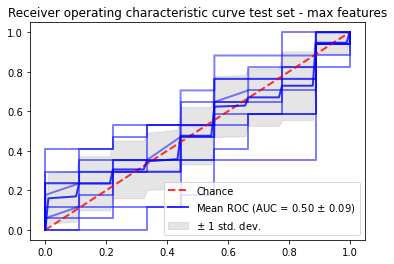

In [104]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="b", lw=2, alpha=0.5)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic curve {which_set} set - max features",
)
ax.legend(loc="lower right")
plt.show()